In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [198]:
pi = np.pi

class Triangulate():
    def __init__(self):
        self.comp_power = 100
    
    def xp(self,a,b):
        """Returns x-prime, the vector representing the primed x-axis in the celestial frame. 
        Points toward the sky, normal to surface of earth"""
        return np.array([np.cos(a)*np.cos(b),np.sin(a)*np.cos(b),np.sin(b)])

    def yp(self,a,b):
        """Returns y-prime in celestial coordinates"""
        return np.array([-np.sin(a),np.cos(a),0])
    
    def zp(self,a,b):
        """Returns z-prime, the vector representation of the primed z-axis in the celestial frame.
        Points north, tangent to surface of earth"""

        return np.array([-np.cos(a)*np.sin(b),-np.sin(a)*np.sin(b),np.cos(b)])


    def vec_prime(self,a,b,v):
        """Transforms a celestial-coordinate vector into a primed frame representation."""
        
        if len(v) == 2:
            v = self.xyz(v[0],v[1])
            
            
        x = np.dot(self.xp(a,b),v)
        z = np.dot(self.zp(a,b),v)
        y = np.dot(self.yp(a,b),v)

        return np.round(np.array([x,y,z]),12)


    def xyz(self,th,ph):
        """Transforms spherical coordinates into xyz coordinates in the celestial frame."""
        return np.array([np.cos(th)*np.cos(ph), np.sin(th)*np.cos(ph), np.sin(ph)])
    

    def find_valid(self, cel_ang_1, cel_ang_2, obs, lims=[[0,2*np.pi],[-np.pi/2,np.pi/2]]):
        """Finds values of alpha and beta for which the observation fits prediction"""
        n=self.comp_power
    
        obsth = obs[0]
        obsph = obs[1]
        
        # Initalize variable space
        A = np.linspace(lims[0][0],lims[0][1],n)
        B = np.linspace(lims[1][0],lims[1][1],n)
        grid = np.meshgrid(A,B)
        
        
        grid[0] += 1*(np.random.rand(n,n)-0.5) * (A[1]-A[0])
        grid[1] += 1*(np.random.rand(n,n)-0.5) * (B[1]-B[0])
        
        flat = np.array([grid[0].flatten(),grid[1].flatten()]).T
            

        # calculate observation vectors
        obj1_xyz = self.xyz(cel_ang_1[0],cel_ang_1[1]) # xyz(obj1[0],obj1[1])
        obj2_xyz = self.xyz(cel_ang_2[0],cel_ang_2[1]) # (obj2[0],obj2[1])


        # For each potential A and B vector, calculate the theoretical change in theta and phi 
        thp = []
        php = []
        for x in flat:
            # Calculate the vectors in a frame [alpha, beta] on the surface of the earth
            vp1 = self.vec_prime(x[0],x[1],obj1_xyz)
            vp2 = self.vec_prime(x[0],x[1],obj2_xyz)
            
            # Calculate theoretical altitude (phi) and azimuth (theta) values of the observation of v1
            thp1 = np.arctan2(vp1[1],vp1[2])
            php1 = np.arcsin(vp1[0])
    
            # Calculate theoretical altitude (phi) and azimuth (theta) values of the observation of v2
            thp2 = np.arctan2(vp2[1],vp2[2])
            php2 = np.arcsin(vp2[0])

            # Calculate theoretical difference between the two angles
            thp += [thp2-thp1]
            php += [php2-php1]

        #back from column to 2d grid
        thp= np.array(thp).reshape(n,n)
        php= np.array(php).reshape(n,n)

        # Create surface that represents the True change in alt-az coords (as observed)
        obs12_th = np.ones((n,n))*obsth
        obs12_ph = np.ones((n,n))*obsph

        # Take the observed delta-theta and delta-phi and compare it to our theoretical ones to figure out
        # which values of A and B would allow for the observed changes.
        
        # Set up empty array for output valeues
        sel_fin = np.array([])
        
        # Start real small with the binsize, extremely restrictive
        binsize = 10**-12
        
        
        # Stop once we have over 100 hits
        while np.sum(np.sum(sel_fin)) < self.comp_power:
            # Check to see if theorized observation for each AB coord are close to observed one
            #print selectth.size()
            
            selectth = (np.abs(thp - obs12_th) < binsize*(lims[0][1]-lims[0][0])/n)
            selectph =  (np.abs(php - obs12_ph) < binsize*(lims[1][1]-lims[1][0])/n)
            
            # Select only those for which theta and phi are close
            sel_fin = selectth*selectph   
            
            # Increase binsize and start over (if the total is less than 100 points)
            binsize *= 1.05
        
        # Return AB coordinates that are close to observation
        
        
        return np.array([grid[0][sel_fin],grid[1][sel_fin]])
    
    def match(self, c1,c2,c3):
        """The purpose of this code is to take 3 curves, calculated with find_valid, and find areas in which their
        values are close. This narrows down the possible AB values"""
        
        # We want to compare two functions whose data points are not necessarily the same. Thus, we have to bin both into
        # a new, global data set.
        
        axis_length = self.comp_power
        
        # First, create bins
        n=axis_length
        alims = np.array([[min(c[0]),max(c[0])] for c in [c1,c2,c3]])
        blims = np.array([[min(c[1]),max(c[1])] for c in [c1,c2,c3]])
        
        da = max([(max(c[0])-min(c[0]))/n for c in [c1,c2,c3]])
        db = max([(max(c[1])-min(c[1]))/n for c in [c1,c2,c3]])
        
        #print alims,blims

        alim = [max(alims.T[0]),min(alims.T[1])]
        blim = [max(blims.T[0]),min(blims.T[1])]
        
        aax = np.linspace(alim[0],alim[1],n)
        bax = np.linspace(blim[0],blim[1],n)
        
        # random added to destroy uniform awkwardness
        grid = np.meshgrid(aax,bax)
        grid[0] += (np.random.rand(n,n) - 0.5) *  (aax[1]-aax[0])
        grid[1] += (np.random.rand(n,n) - 0.5) * (bax[1]-bax[0])
        
        coors = np.array([grid[0].flatten(),grid[1].flatten()]).T
        
        # specify width for which points are accepted into the bin( I used twice the separation distance). The 
        # functions we are trying to match are discrete and have errors, so r must be fairly large.
        rth = 2*da
        rph = 2*db

        # Go through each data set (each observation run though find_valid), and select the points where 
        # all three values fall into bin (tiered to lower computational power)
        h = []
        
        for c in coors:
            select1 = (c1[0] > c[0]) * (c1[0] < (c[0] + rth)) * (c1[1] > c[1]) * (c1[1] < (c[1] + rph))

            if (sum(select1) > 0):
                select2 = (c2[0] > c[0]) * (c2[0] < (c[0] + rth)) * (c2[1] > c[1]) * (c2[1] < (c[1] + rph))

                if sum(select2) > 0:
                    select3 = (c3[0] > c[0]) * (c3[0] < (c[0] + rth)) * (c3[1] > c[1]) * (c3[1] < (c[1] + rph))

                    if sum(select3) > 0:
                        h += [c]
                        
        print "Number of points: " + str(len(h))
                                                
        # h is now an array containing all of the bin points for which there is a point from each data set within
        out = np.array(h).T
        out[0] += rth/2
        out[1] += rph/2
        return out
    
    
    def tri(self, v1, v2, v3, obs_v1_v2, obs_v2_v3, accuracy = 0.01):
        """given v1,v2,v3, three celestial coordinates for objects, and observed changes in altitude and azimuth of those
        objects, returns exact coordinates of normal vector. i.e. latitude and longitude"""
        
        
        # Calculate difference between v1 and v3
        obs_v1_v3 = [obs_v1_v2[0]+ obs_v2_v3[0], obs_v1_v2[1]+ obs_v2_v3[1]]
        
        lims = [[0,2*np.pi],[-np.pi/2,np.pi/2]]
        
        accth=2
        accph=1
        
        while (accth > accuracy) or (accph > accuracy):
            print "Running analysis..."
            
            print lims
            
            c1 = T.find_valid(v1, v2, obs_v1_v2, lims=lims)
            c2 = T.find_valid(v1, v3, obs_v1_v3, lims=lims)
            c3 = T.find_valid(v2, v3, obs_v2_v3, lims=lims)
            
            out = T.match(c1,c2,c3)
            
            accth = np.std(out[0])/np.sqrt(len(out[0]))
            accph = np.std(out[1])/np.sqrt(len(out[1]))
            
            a = [np.average(out[0]),np.average(out[1])]
            
            lims = [[min(out[0]),max(out[0])], [min(out[1]), max(out[1])]]
            
            print "Achieved errors: " + str(accth) + "   and   " + str(accph)
            

            
            
        print "Done."
        err = [accth, accph]
        return a, err
        
        
    
    
T = Triangulate()

"""v1 = [3*pi/4+pi/2,1.6*pi/4]
v2 = [3.1*pi/4+pi/2,1.5*pi/4]
v3 = [2.9*pi/4+pi/2,1.2*pi/4]

lims = [[0,2*np.pi],[-np.pi/2,np.pi/2]]"""

'v1 = [3*pi/4+pi/2,1.6*pi/4]\nv2 = [3.1*pi/4+pi/2,1.5*pi/4]\nv3 = [2.9*pi/4+pi/2,1.2*pi/4]\n\nlims = [[0,2*np.pi],[-np.pi/2,np.pi/2]]'

In [199]:
T = Triangulate()
stats = T.tri(v1,v2,v3,v2_v1,v3_v2,accuracy=0.00001)

Running analysis...
[[0, 6.283185307179586], [-1.5707963267948966, 1.5707963267948966]]
0.112094292195 0.0422605147827
Number of points: 158
Achieved errors: 0.00272755252131   and   0.00334010246504
Running analysis...
[[0.74716512811902769, 0.87795075573592463], [0.40362744666597183, 0.58162627633561848]]
0.000918617731129 0.000798476926008
Number of points: 57
Achieved errors: 0.000742018998676   and   0.000598008922557
Running analysis...
[[0.77703874378243953, 0.79500803008821119], [0.51520114300105602, 0.53344383529758244]]
9.1596897966e-05 7.85199348439e-05
Number of points: 19
Achieved errors: 0.000158959974403   and   0.000135330570501
Running analysis...
[[0.78446594989140173, 0.78623847304697281], [0.52263202272849996, 0.52411292044315316]]
7.98760641355e-06 7.41335772059e-06
Number of points: 32
Achieved errors: 6.28882955433e-06   and   5.2909777816e-06
Done.


In [201]:
st = np.array(stats)
cent = np.array(p)

(st[0]-p)/st[1]

array([ 2.96963354,  5.42591087])

In [193]:
T = Triangulate()

#v1 = [ 0.35355339 , 0.61237244 , 0.70710678]
#v2 = [ 0.1545085  , 0.26761657 , 0.95105652]

lims = [[0.78458210596208044, 0.78610770620912584], [0.52275268198225833, 0.52429801731024217]]


c1 = T.find_valid(v1, v2, v2_v1, lims=lims)
c2 = T.find_valid(v1, v3, v3_v1, lims=lims)
c3 = T.find_valid(v2, v3, v3_v2, lims=lims)

out = T.match(c1,c2,c3)


7.84165524938e-06 7.07651347401e-06
Number of points: 37


<IPython.core.display.Javascript object>


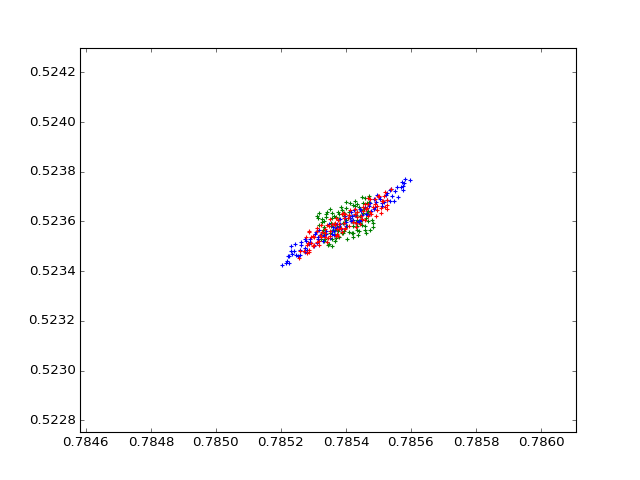

0.785402455622


(0.5227526819822583, 0.5242980173102422)

In [181]:
f = plt.figure()

plt.scatter(out[0],out[1],marker='.',c = 'black',alpha=0.1)
plt.scatter(c3[0],c3[1],marker='+',c='g')
plt.scatter(c1[0],c1[1],marker='+',c='b')
plt.scatter(c2[0],c2[1],marker='+',c='r')

print np.average(out[0])


plt.xlim(lims[0][0],lims[0][1])
plt.ylim(lims[1][0],lims[1][1])

In [68]:
T = Triangulate()

p = [pi/4,pi/6]

v1 = [2*pi/6,pi/4]
v2 = [2*pi/6,2*pi/5]
v3 = [0*pi/6,2*pi/5]

vp1 = T.vec_prime(p[0],p[1],v1)
vp2 = T.vec_prime(p[0],p[1],v2)
vp3 = T.vec_prime(p[0],p[1],v3)

print vp1,vp2

v2_v1 = [np.arctan2(vp2[1],vp2[2]) - np.arctan2(vp1[1],vp1[2]), np.arcsin(vp2[0]) - np.arcsin(vp1[0])]
v3_v2 = [np.arctan2(vp3[1],vp3[2]) - np.arctan2(vp2[1],vp2[2]), np.arcsin(vp3[0]) - np.arcsin(vp2[0])]
v3_v1 = [np.arctan2(vp3[1],vp3[2]) - np.arctan2(vp1[1],vp1[2]), np.arcsin(vp3[0]) - np.arcsin(vp1[0])]

#av,err= T.tri(v1,v2,v3,v1_v2,v2_v3,0.001)

[ 0.94505974  0.1830127   0.27086608] [ 0.73402601  0.07997948  0.67439536]
